# Inpainting di immagini satellitari

  Studente : Giulia Torsani, Matricola: 0001020194

# Import necessari

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tensorflow.keras import layers, models
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv2D, LeakyReLU, MaxPooling2D, UpSampling2D, BatchNormalization, concatenate, Concatenate, Input
from tensorflow.keras.metrics import MeanIoU
from keras import backend as K

Downloading e preparazione del dataset

In [ ]:
ds_train, ds_info = tfds.load(
    'eurosat/rgb',
    shuffle_files=False,
    #as_supervised=True,  # Returns a tuple (img, label) instead of a dictionary {'image': img, 'label': label}
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteNVU2HA/eurosat-train.tfrecord*...:   0%|      …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [ ]:
ds_train = ds_train['train']

In [ ]:
ds_train = ds_train.shuffle(1000, seed = 42)

In [ ]:
train_dataset = ds_train.take(20000)
test_dataset = ds_train.skip(20000)

Il generatore fornisce i dati di addestramento. Creiamo una maschera disegnando linee verticali casuali con angoli diversi e con larghezza variabile. La porzione dell'immagine conservata è quella sotto la maschera.

In [ ]:
def generator(dataset,nolines=9):
    while True:  # Start an infinite loop
        for batch in dataset:
            images = batch["image"]
            images_np = images.numpy()

            masks = np.zeros((batch_size, 64, 64))
            for i in range(batch_size):
                for j in range(nolines):
                    start_point = (np.random.randint(0, 64 - 1), 0)
                    end_point = (np.random.randint(0, 64 - 1), 63)
                    thickness = np.random.randint(2, 3)
                    masks[i] = cv2.line(masks[i], start_point, end_point, (1), thickness)

            images_np = images_np / 255.0
            masks = np.stack(((masks),) * 3, axis=-1)

            yield (images_np * masks, images_np)

# Batch the datasets
batch_size = 8
train_dataset_batched = train_dataset.batch(batch_size)
test_dataset_batched = test_dataset.batch(batch_size)

# Create generators for the batched datasets
train_generator = generator(train_dataset_batched)
test_generator = generator(test_dataset_batched)

Visualizziamo i dati. Nella prima riga mostriamo le immagini deteriorate, e nella seconda gli originali che devono essere ricostruite.

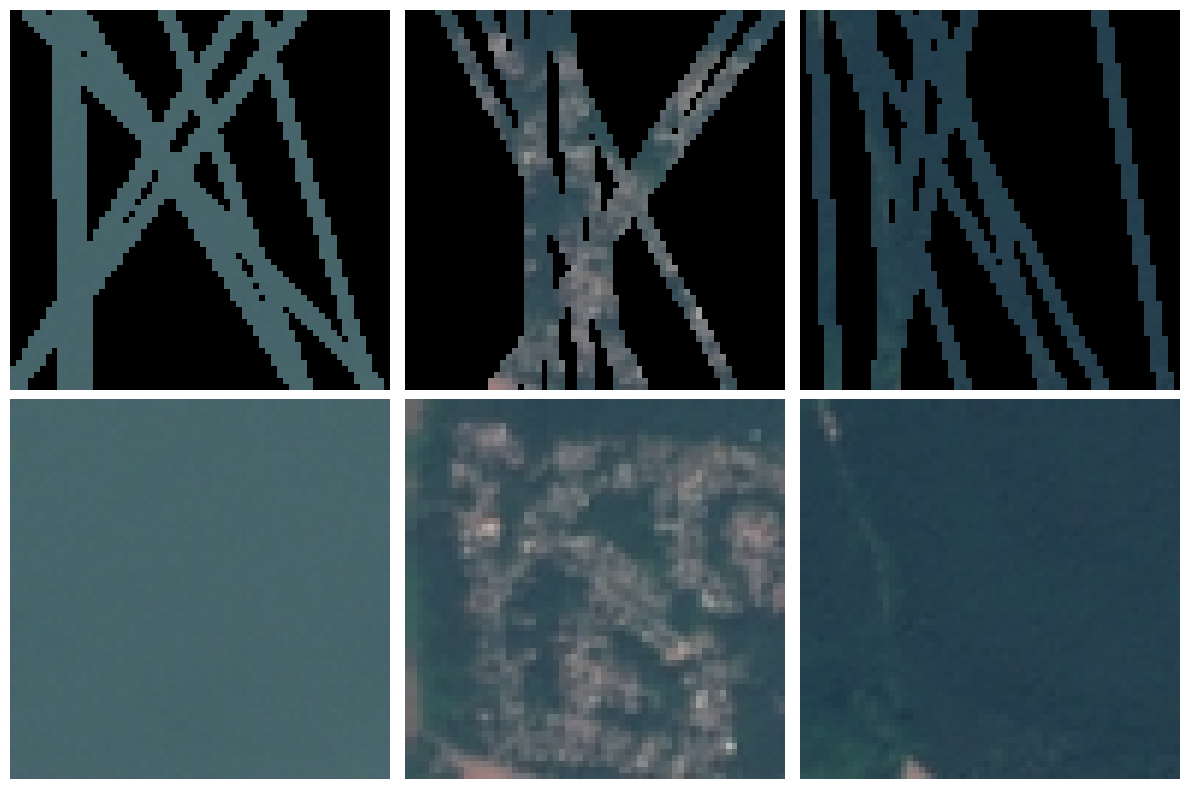

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))  # Adjust figsize as needed
a,b = next(train_generator)
for i in range(3):
  # Plot image on each subplot
  axes[0,i].imshow(a[i])  # Use cmap='gray' if your images are grayscale
  axes[0,i].axis('off')  # Turn off axis
  axes[1,i].imshow(b[i])  # Use cmap='gray' if your images are grayscale
  axes[1,i].axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into the figure area.
plt.show()

# Definizione del modello utilizzato: U-net

La scelta è stata dettata dal fatto che tale rete risulta efficace per problemi legati all' applicazione di segmentazione e ricostruzione delle immagini.

Nel particolare ambito dell'inpainting tale rete ottiene buoni risultati grazie alla sua capacità di catturare dettagli a diverse scale spaziali, combinando informazioni globali e locali e preservando dettagli importanti attraverso le skip connections.

Per aumentare l'efficenza sono stati aggiunti layers e filtri sia all'Encoder che al Decoder, utilizzando BatchNormalization per migliorare la stabilità dell'addestramento e per ridurre l'overfitting.

E' stata inoltre effettuata un'ulteriore ottimizzazione utilizzando leaky ReLU : una variante di ReLU che mitiga il problema dei "neuroni morti"(neuroni che danno sempre come output 0) con piccoli valori negativi.

In [ ]:
def decoder_block(inputs, skip, filters, kernel_size=(3, 3), padding='same', activation='relu'):
    conv = Conv2D(filters, kernel_size, padding=padding)(inputs)
    conv = LeakyReLU(alpha=0.2)(conv)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, kernel_size, padding=padding)(conv)
    conv = LeakyReLU(alpha=0.2)(conv)
    conv = BatchNormalization()(conv)

    # Aggiungo un layer di convoluzione per regolare le dimensioni di skip
    skip = Conv2D(filters, (1, 1), padding='same')(skip)
    up = UpSampling2D((2, 2))(conv)
    # Concatena i tensori
    up = Concatenate()([up, skip])
    return conv, up


def inpainting_model():
    input_layer = Input(shape=(64, 64, 3))

    # Encoder
    conv1 = Conv2D(16, (3, 3), padding='same')(input_layer)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), padding='same')(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, (3, 3), padding='same')(pool1)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), padding='same')(conv2)
    conv2 = LeakyReLU(alpha=0.2)(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, (3, 3), padding='same')(pool2)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), padding='same')(conv3)
    conv3 = LeakyReLU(alpha=0.2)(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    # Decoder
    conv4, up4 = decoder_block(pool3, conv3, 64)
    conv5, up5 = decoder_block(up4, conv2, 32)
    conv6, up6 = decoder_block(up5, conv1, 16)

    # Concateno
    concat = Concatenate()([up6, conv1])

    # Output layer
    output_layer = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(concat)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

Come loss di training utilizzo la BinaryCrossentropy, poichè si lavora con maschere binarie (pixel che devono essere inpainted o no).

Come metrica utilizzo MeanIoU, che mi dà in output un valore compreso tra 0 e 1 (più il valore si avvicina ad 1, più la rete avrà prestazioni migliori).

In questo caso specifico vengono utilizzate 2 classi, quindi l'IoU viene calcolato separatamente per ciascuna classe e la media viene restituita come metrica complessiva.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 16)           448       ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 16)           0         ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 16)           64        ['leaky_re_lu[0][0]']         
 Normalization)                                                                               

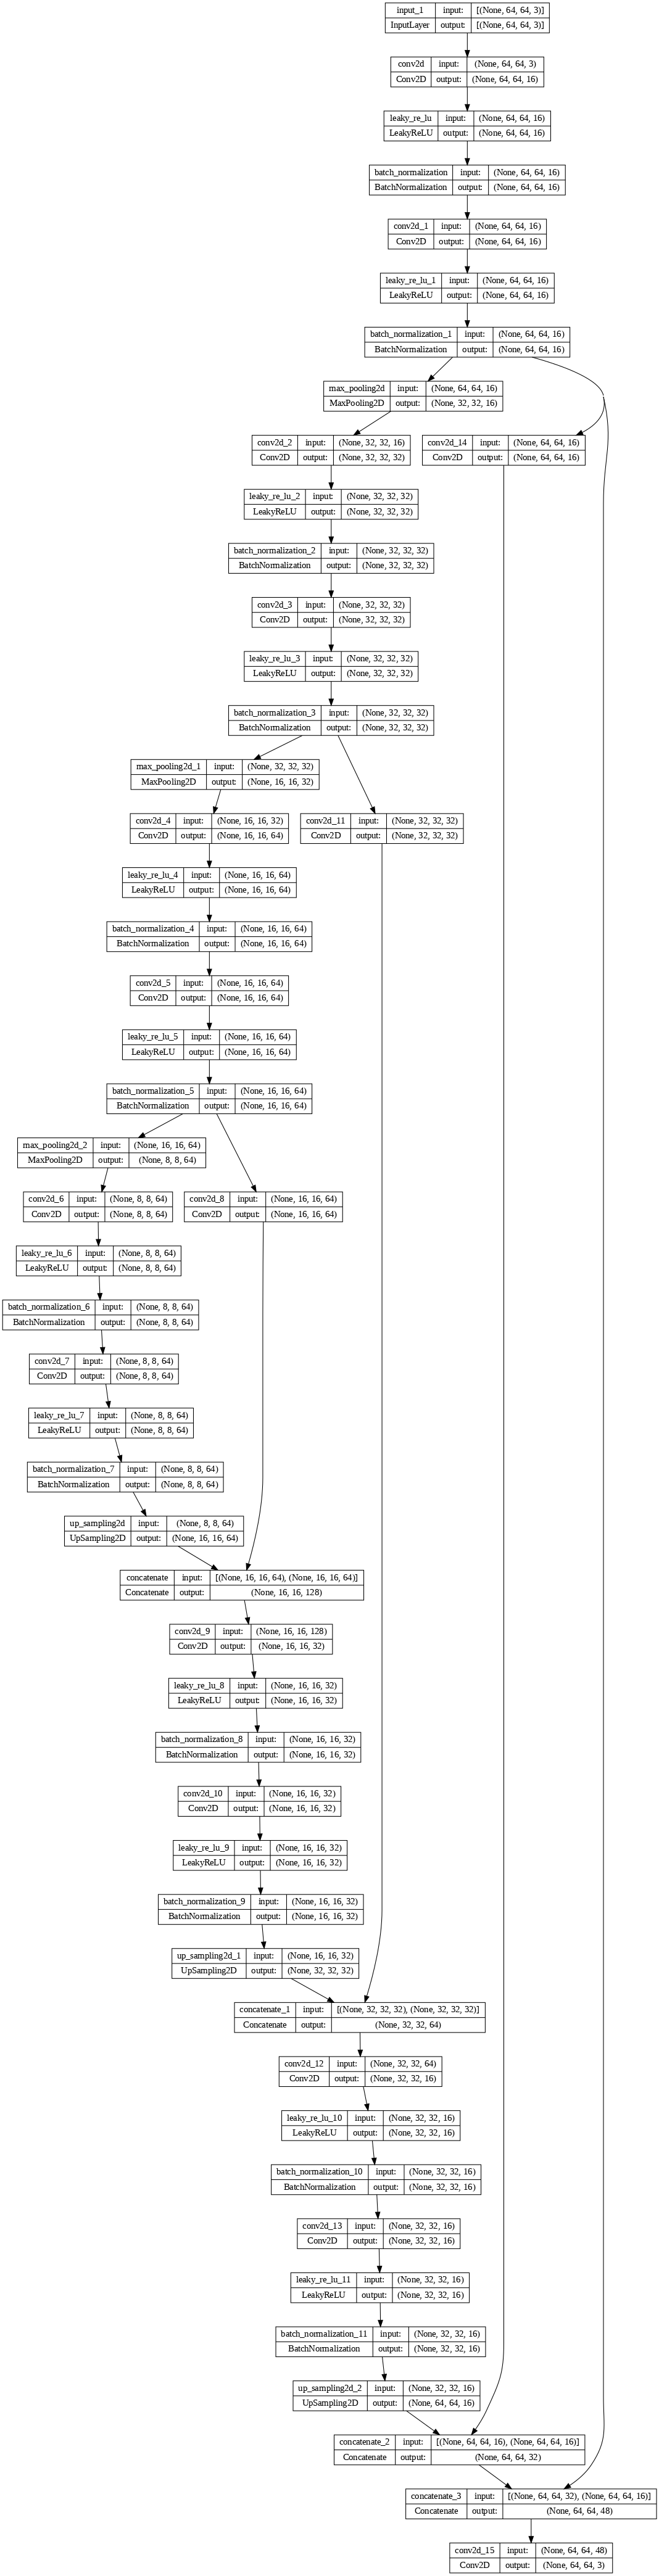

In [ ]:
# Crea un'istanza del modello
model = inpainting_model()

# Compila il modello
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[MeanIoU(num_classes=2)])
model.summary()
plot_model(model, show_shapes=True, dpi=76, to_file='model.png')

# Fase di trainig

In [ ]:
#monitoro le loss e le metriche di MeanIoU durante l'addestramento del modello e ne calcolo la media
# Liste per memorizzare le metriche IoU
train_iou_history = []
test_iou_history = []

# Liste per memorizzare le loss di addestramento e test
train_loss_history = []
test_loss_history = []

# Imposta il numero massimo di epoche e il contatore delle epoche
max_epochs = 30
epoch_counter = 0

# Aggiunta di EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Addestra il modello per il numero massimo di epoche
for epoch in range(max_epochs):
    epoch_counter += 1

    # Addestra il modello per una singola epoca con monitoraggio del set di test
    history = model.fit(train_generator, steps_per_epoch=len(train_dataset) // batch_size,
                        epochs=1, verbose=1, validation_data=test_generator,
                        validation_steps=len(test_dataset) // batch_size, callbacks=[early_stopping])

    # Salva le metriche sul set di addestramento e test
    train_iou_history.append(history.history['val_mean_io_u'][0])
    test_iou = model.evaluate(test_generator, steps=len(test_dataset) // batch_size, verbose=0)
    test_iou_history.append(test_iou[1])  # L'indice 1 corrisponde alla metrica mean_io_u

    # Salva le loss sul set di addestramento e test
    train_loss_history.append(history.history['loss'][0])
    test_loss_history.append(history.history['val_loss'][0])

# Calcola la media delle metriche alla fine del training
avg_train_loss = np.mean(train_loss_history)
avg_test_loss = np.mean(test_loss_history)
avg_train_iou = np.mean(train_iou_history)
avg_test_iou = np.mean(test_iou_history)

# Stampa la media delle metriche e delle loss
print(f'Average Train Loss: {avg_train_loss:.4f}')
print(f'Average Test Loss: {avg_test_loss:.4f}')
print(f'Average Train IoU: {avg_train_iou:.4f}')
print(f'Average Test IoU: {avg_test_iou:.4f}')

2500/2500 [==============================] - 50s 20ms/step - loss: 0.6116 - mean_io_u: 0.4983 - val_loss: 0.6124 - val_mean_io_u: 0.4983
Average Train Loss: 0.6129
Average Test Loss: 0.6132
Average Train IoU: 0.4983
Average Test IoU: 0.4983


Visualizzazione grafica delle loss e delle metriche IoU.

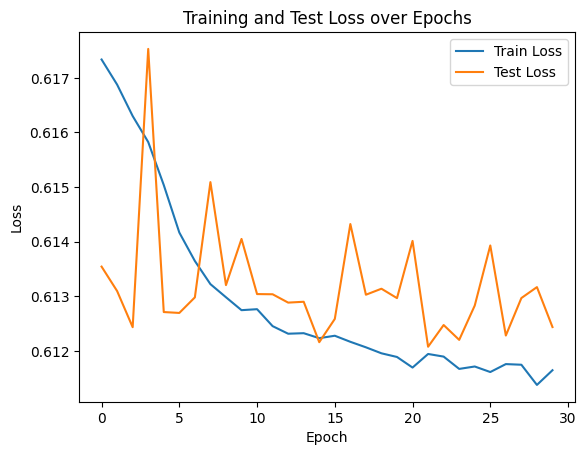

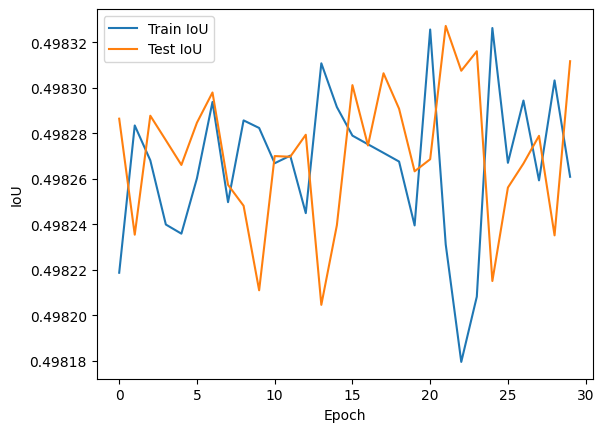

In [ ]:
# Visualizza il grafico delle loss
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss over Epochs')
plt.show()

# Visualizza il grafico delle metriche IoU
plt.plot(train_iou_history, label='Train IoU')
plt.plot(test_iou_history, label='Test IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()


# Fase di validazione

Calcolo l'mse su 10000 immagini generate dal set di test.

Ripeto il calcolo precedente 10 volte e fornisco il valore medio e la deviazione standard.

In [ ]:
# Funzione per calcolare l'MSE usando la backend di Keras
def mse_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis=-1)

# Imposta la loss function del modello
model.compile(optimizer='adam', loss=mse_loss)

# Numero di iterazioni di testing
num_testing_iterations = 10

# Numero di immagini da valutare durante il testing
num_images_to_evaluate = 10000

# Lista per memorizzare i risultati MSE
mse_values = []

# Loop sulle iterazioni di testing
for iteration in range(1, num_testing_iterations + 1):
    # Calcola l'MSE per tutto il set di test
    mse_iteration = model.evaluate(test_generator, steps=num_images_to_evaluate // batch_size, verbose=0)

    # Aggiungi il risultato alla lista per questa iterazione
    mse_values.append(mse_iteration)

    # Stampa il risultato per questa iterazione
    print(f'Iterazione {iteration}/{num_testing_iterations} - MSE: {mse_iteration}')

# Calcola il valore medio e la deviazione standard del MSE su tutte le iterazioni
mean_mse = np.mean(mse_values)
std_dev_mse = np.std(mse_values)

# Stampa i risultati complessivi
print(f'\nMedia MSE su {num_testing_iterations} iterazioni: {mean_mse}')
print(f'Deviazione standard MSE su {num_testing_iterations} iterazioni: {std_dev_mse}')

Iterazione 1/10 - MSE: 0.002909350208938122
Iterazione 2/10 - MSE: 0.0029062735848128796
Iterazione 3/10 - MSE: 0.002887762151658535
Iterazione 4/10 - MSE: 0.002884178888052702
Iterazione 5/10 - MSE: 0.0028645521961152554
Iterazione 6/10 - MSE: 0.002902816981077194
Iterazione 7/10 - MSE: 0.002910791663452983
Iterazione 8/10 - MSE: 0.0028839586302638054
Iterazione 9/10 - MSE: 0.0029126880690455437
Iterazione 10/10 - MSE: 0.0028929843101650476

Media MSE su 10 iterazioni: 0.0028955356683582067
Deviazione standard MSE su 10 iterazioni: 1.475136923980438e-05


# Visualizzo alcune immagini

1/1 [==============================] - 1s 930ms/step


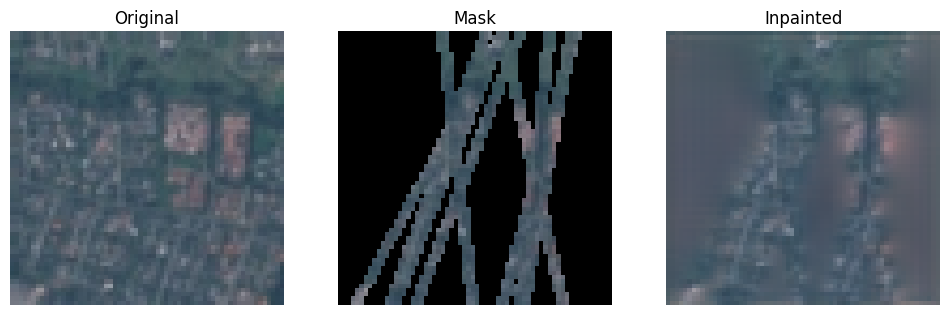

1/1 [==============================] - 0s 18ms/step


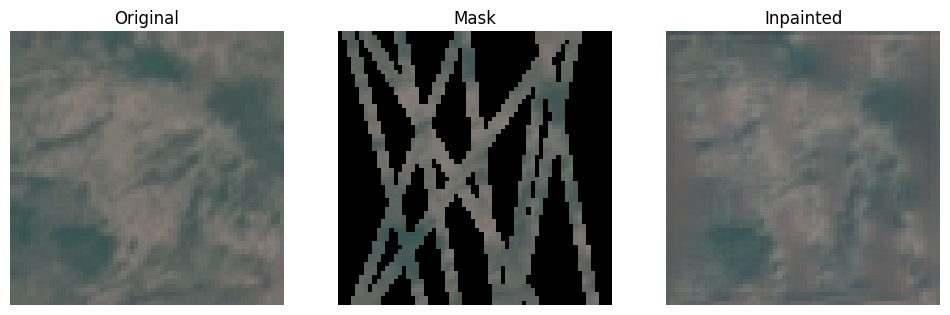

1/1 [==============================] - 0s 19ms/step


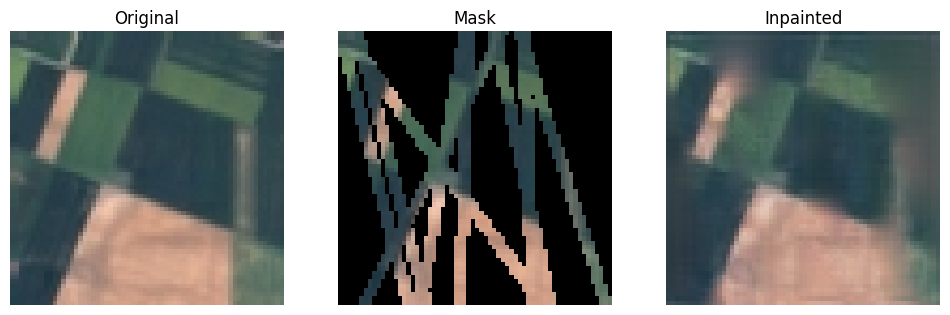

1/1 [==============================] - 0s 18ms/step


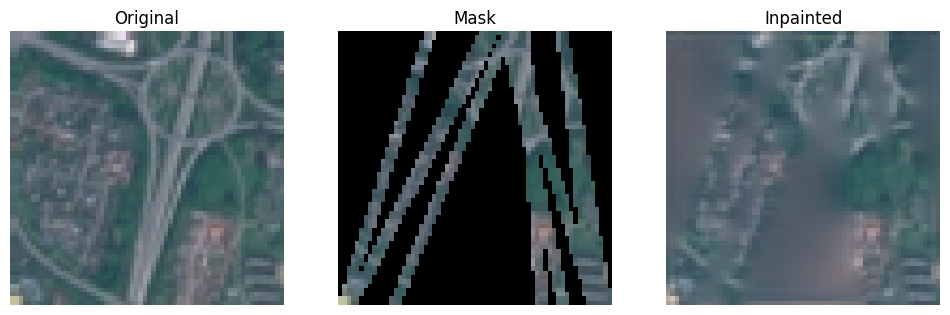

1/1 [==============================] - 0s 18ms/step


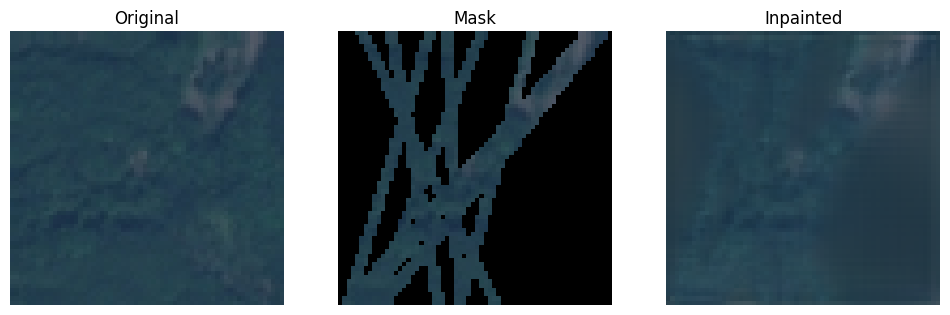

1/1 [==============================] - 0s 19ms/step


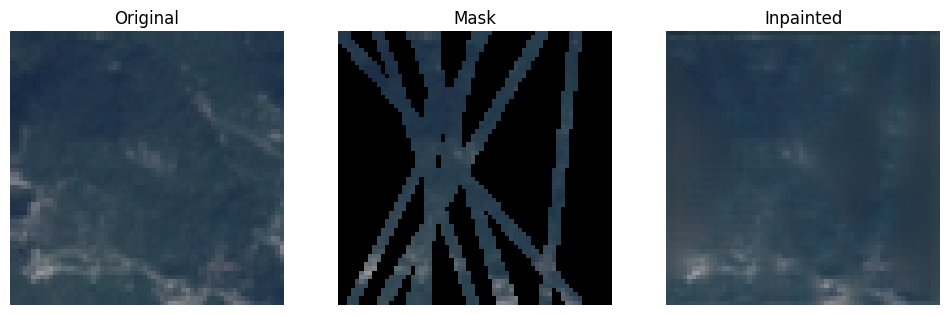

1/1 [==============================] - 0s 18ms/step


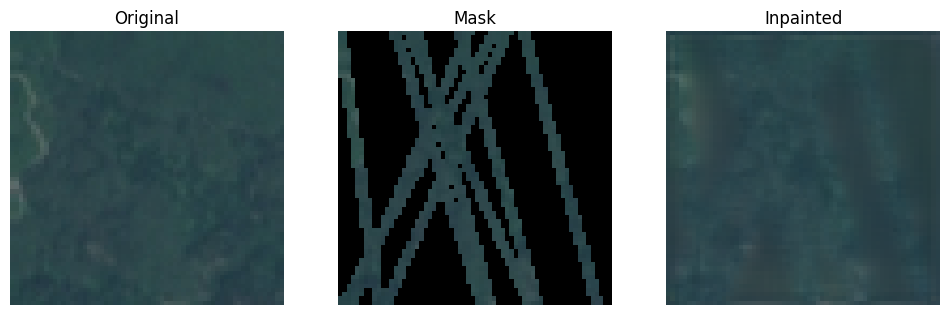

1/1 [==============================] - 0s 18ms/step


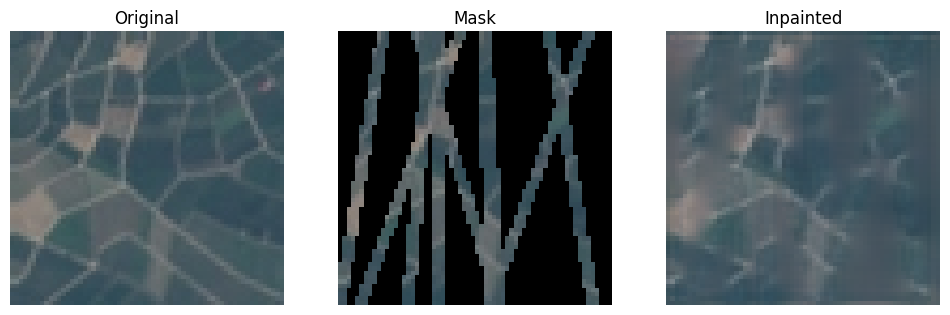

1/1 [==============================] - 0s 19ms/step


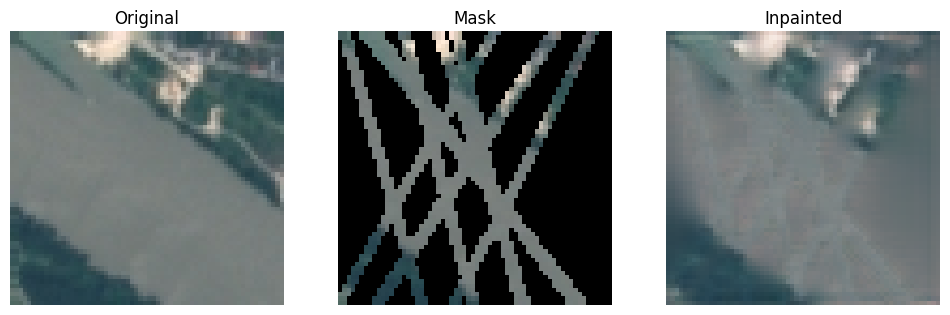

1/1 [==============================] - 0s 29ms/step


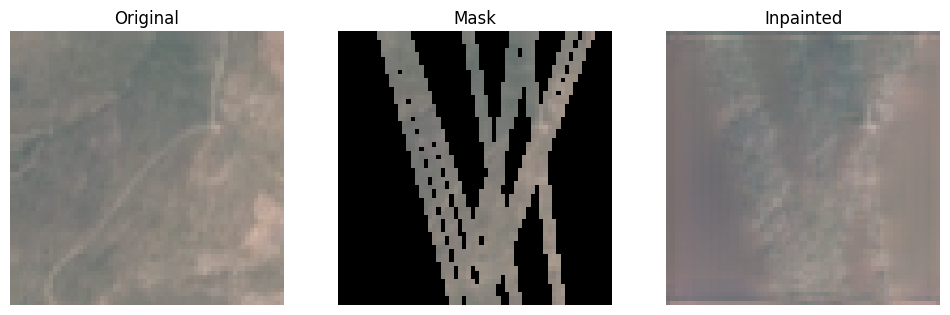

In [ ]:
# Funzione per visualizzare immagini
def plot_images(original, mask, inpainted):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

    # Visualizza l'immagine originale
    axes[0].imshow(original)
    axes[0].set_title('Original')
    axes[0].axis('off')

    # Visualizza la maschera
    axes[1].imshow(mask)
    axes[1].set_title('Mask')
    axes[1].axis('off')

    # Visualizza l'immagine inpaintata
    axes[2].imshow(inpainted)
    axes[2].set_title('Inpainted')
    axes[2].axis('off')

    plt.show()

# Numero di triplette da visualizzare
num_triplets = 10

# Loop per visualizzare più triplette
for _ in range(num_triplets):
    # Estrai un batch dal generatore di test
    sample_batch = next(test_generator)
    sample_image_masked, sample_image_original = sample_batch

    # Seleziona una singola immagine dal batch (con maschera)
    input_image = sample_image_masked[0:1]  # considera solo la prima immagine nel batch

    # Genera la predizione del modello
    prediction = model.predict(input_image)

    # Estrai l'immagine originale dal batch
    original_image = sample_image_original[0:1]  # considera solo la prima immagine nel batch

    # Visualizza le immagini
    plot_images(original_image[0], input_image[0], prediction[0])